# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работы:
1. Предобработка и исследовательский анализ данных. Объединение всех данных в одну таблицу.

2. Машинное обучение

2.1. Разделение на выборки

2.2. Кодирование, масштабирование

2.3. Обучение

2.4. Проверка качества модели на тестовой выборке

2.5. Исследование важности признаков лучшей модели

3. Отчет

3.1. Какие трудности возникли, какие ключевые шаги выделяем?

3.2. Лучшая модель, гиперпараметры.

3.3. Список признаков используемых для обучения лучшей модели.

#Часть 1

## Предобработка и исследовательский анализ данных. Объединение всех данных в одну таблицу.

Импортируем все необходимые библиотеки

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from multiprocessing import Pool
from sklearn.metrics import get_scorer_names, make_scorer, roc_auc_score

!pip install shap
import shap
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 220523

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
try:
    internet_new = pd.read_csv('C:\Anna\Yandex_Praktikum\Final_project\Datasets\internet_new.csv')
    contract_new = pd.read_csv('C:\Anna\Yandex_Praktikum\Final_project\Datasets\contract_new.csv')
    personal_new = pd.read_csv('C:\Anna\Yandex_Praktikum\Final_project\Datasets\personal_new.csv')
    phone_new = pd.read_csv('C:\Anna\Yandex_Praktikum\Final_project\Datasets\phone_new.csv')
except:
    internet_new = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    contract_new = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal_new = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    phone_new = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

 Выведем info, head и describe по нашим датасетам
  

In [ ]:
data_list=[internet_new, contract_new, personal_new, phone_new]
for data in data_list:
    display(data.info())
    display(data.head())
    display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Посмотрим на нечисловые значение в колонке 'TotalCharges'

In [ ]:
contract_new['TotalCharges'] = pd.to_numeric(contract_new['TotalCharges'], errors='coerce')
print(contract_new[pd.isna(contract_new['TotalCharges'])]['TotalCharges'])

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64


In [ ]:
contract_new[contract_new.isnull().any(1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Заменим NAN на 0

In [ ]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].fillna(0)
contract_new[contract_new.isnull().any(1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


Посмотрим на тип данных в колонке TotalCharges

In [ ]:
print(contract_new['TotalCharges'].astype)

<bound method NDFrame.astype of 0         31.04
1       2071.84
2        226.17
3       1960.60
4        353.50
         ...   
7038    2035.20
7039    7430.40
7040     325.60
7041     520.80
7042    7251.82
Name: TotalCharges, Length: 7043, dtype: float64>


Округлим числа до целого и поменяем тип данных на целое число для TotalCharges и MonthlyCharges

In [ ]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].round()
contract_new['MonthlyCharges'] = contract_new['MonthlyCharges'].round()
contract_new['TotalCharges'] = contract_new['TotalCharges'].convert_dtypes()
contract_new['MonthlyCharges'] = contract_new['MonthlyCharges'].convert_dtypes()
print(contract_new['TotalCharges'].head())
print(contract_new['MonthlyCharges'].head())

0      31
1    2072
2     226
3    1961
4     354
Name: TotalCharges, dtype: Int64
0    30
1    57
2    54
3    42
4    71
Name: MonthlyCharges, dtype: Int64


Там, где не заполнено end date, то есть клиент продолжает пользоваться услугами на дату среза - заполняю датой среза(1.02.20)

In [ ]:
contract_new['EndDate'] = contract_new['EndDate'].replace(['No'], ['2020-02-01'])

Приведем поля BeginDate и EndDate к типу datetime

In [ ]:
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'],format = '%Y-%m-%d')
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'],format = '%Y-%m-%d')

Объединим данные в одну таблицу

In [ ]:
data = contract_new.set_index('customerID').join(phone_new.set_index('customerID'))
data = data.join(personal_new.set_index('customerID'))
data = data.join(internet_new.set_index('customerID'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   Int64         
 6   TotalCharges      7043 non-null   Int64         
 7   MultipleLines     6361 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Заполним пропуски нулями

In [ ]:
data.fillna(0, inplace = True)

Визуализируем данные по месячным расходам

<function matplotlib.pyplot.show(close=None, block=None)>

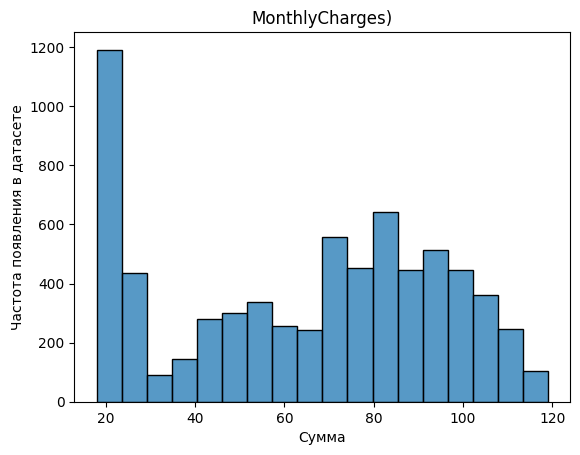

In [ ]:
sns.histplot(data['MonthlyCharges'])
plt.title('MonthlyCharges)')
plt.xlabel('Сумма')
plt.ylabel('Частота появления в датасете')
plt.show

На графике мы видим три пика - 20, 40, 90 тыс.

Визуализируем данные по месячным расходам

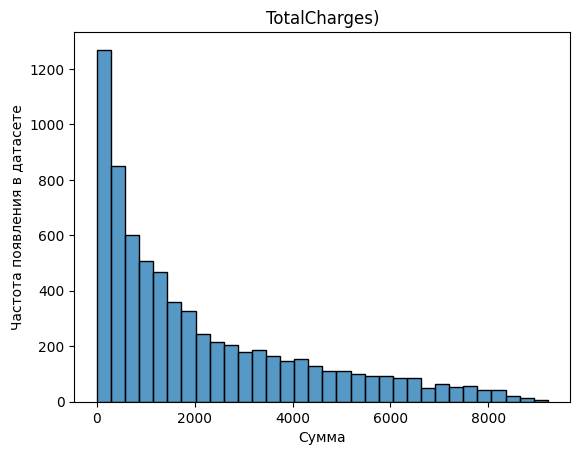

In [ ]:
sns.histplot(data['TotalCharges'])
plt.title('TotalCharges)')
plt.xlabel('Сумма')
plt.ylabel('Частота появления в датасете');

На графике мы видим ниспадающией тренд - чем больше сумма расходов, тем меньшее количество клиентов ее тратит.

Построим графики по датам начала и окончания сотрудничества

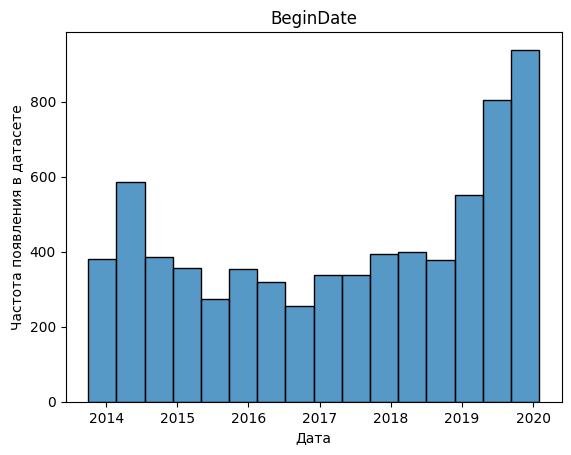

In [ ]:
sns.histplot(data['BeginDate'])
plt.title('BeginDate')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

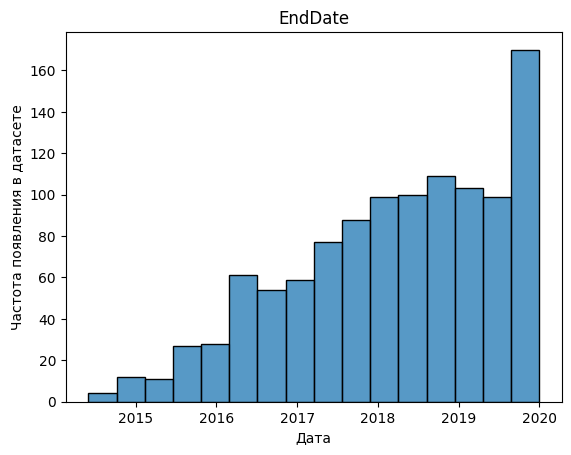

In [ ]:
sns.histplot(data.query('EndDate != "2020-02-01"')['EndDate'])
plt.title('EndDate')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

По графикам прихода и ухода клиентов из компании, можно сказать, что до 2019 года приходило примерно одно и то же количество клиентов, а потом начался рост. В конце 2019-го начале 2020 начался резкий рост оттока.

### Выводы:

Мне в работу переданы 4 датасета:

1. internet_new - 5517 строк. Содержит данные о различных опциях и сервисах, которыми пользуются клиенты. Тип данных object.
2. contract_new - 7043 строк. Содержит данные о суммах платежей клиентов, типах выставления счетов, дате начала контракта. Тип данных object, кроме MonthlyCharges - float64.
3. personal_new 7043 строк. Содержит данные о клиентах - пол, является ли возрастным, есть ли партнер, есть ли иждивенцы. Тип данных object, кроме SeniorCitizen - int64.
4. phone_new 6361 строк. Содержит данные о наличии или отсуствии MultipleLines. Тип данных object.

- Ни в одном из датасетом пропусков в данных нет
- Целевой признак - колонка EndDate в таблице internet_new. Нам предстоит решить задачу классификации
- В колонке TotalCharges были Наны - я вывела информацию по ним и увидела, что это новые клиенты, подключенные 1 февраля 2020 года с продолжительностью контакта от 1-го до 2-х лет. Я заменила NAN на 0.
- В колонках TotalCharges и MonthlyCharges два знака после запятой. Для целей машинного обучения, я округлила значения до целого.
- Там, где не заполнено end date, то есть клиент продолжает пользоваться услугами на дату среза - я заполнила датой среза(1.02.23)
- Тип данных в полях BeginDate и EndDate поменяла на datetime
- Объединила все данные в одну таблицу и заменила пропуски в ней нулями.
- По графикам месячных расходов видно, что наиболее распространенная сумма, которую клиенты тратят в месяц - это 20 тысяч рублей, на графике есть еще 2 пика - 40 и 90 тыс. рублей. По графику общих расходов видно, что чем больше сумма расходов, тем меньшее количество клиентов ее тратит. По графикам прихода и ухода клиентов из компании, можно сказать, что до 2019 года приходило примерно одно и то же количество клиентов, а потом начался рост. В конце 2019-го начале 2020 начался резкий рост оттока.





#Часть 2

## Машинное обучение

### Разделение на выборки

Добавим столбец 'TotalTime', который покажет, сколько дней клиент являлся клиентом

In [ ]:
data['TotalTime'] = (data['EndDate'] - data['BeginDate']).dt.days

Добавим столбец 'CustomerLeft', который будет целевым признаком и проверим баланс классов

In [ ]:
data['CustomerLeft'] = (data['EndDate'] != '2020-02-01').astype(int)
data['CustomerLeft'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: CustomerLeft, dtype: float64

16% ушло, 84% осталось

Удалим столбцы 'BeginDate', 'EndDate', т.к. они больше нам не нужны


In [ ]:
data = data.drop(['BeginDate', 'EndDate'], axis=1)

Посмотрим на наш датасет после изменений

In [ ]:
data.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TotalTime,CustomerLeft
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,30,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,31,0
5575-GNVDE,One year,No,Mailed check,57,2072,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,54,226,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),42,1961,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,71,354,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No,153,0


Построим матрицу корреляции 𝜙k

In [ ]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'TotalTime', 'CustomerLeft']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TotalTime,CustomerLeft
Type,1.00,0.11,0.28,0.39,0.47,0.24,0.00,0.09,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.63,0.09
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.10,0.00,0.24,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.03,0.08
PaymentMethod,0.28,0.37,1.00,0.40,0.34,0.17,0.00,0.29,0.24,0.22,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.35,0.21
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.71,0.00,0.31,0.20,0.19,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.39,0.23
TotalCharges,0.47,0.20,0.34,0.71,1.00,0.47,0.00,0.14,0.38,0.08,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.85,0.30
MultipleLines,0.24,0.10,0.17,0.71,0.47,1.00,0.00,0.09,0.09,0.01,0.74,0.54,0.56,0.56,0.54,0.59,0.59,0.35,0.11
gender,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
SeniorCitizen,0.09,0.24,0.29,0.31,0.14,0.09,0.00,1.00,0.02,0.32,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.06,0.09
Partner,0.18,0.01,0.24,0.20,0.38,0.09,0.00,0.02,1.00,0.65,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.45,0.23
Dependents,0.15,0.17,0.22,0.19,0.08,0.01,0.00,0.32,0.65,1.00,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.20,0.05


Визуализируем матрицу

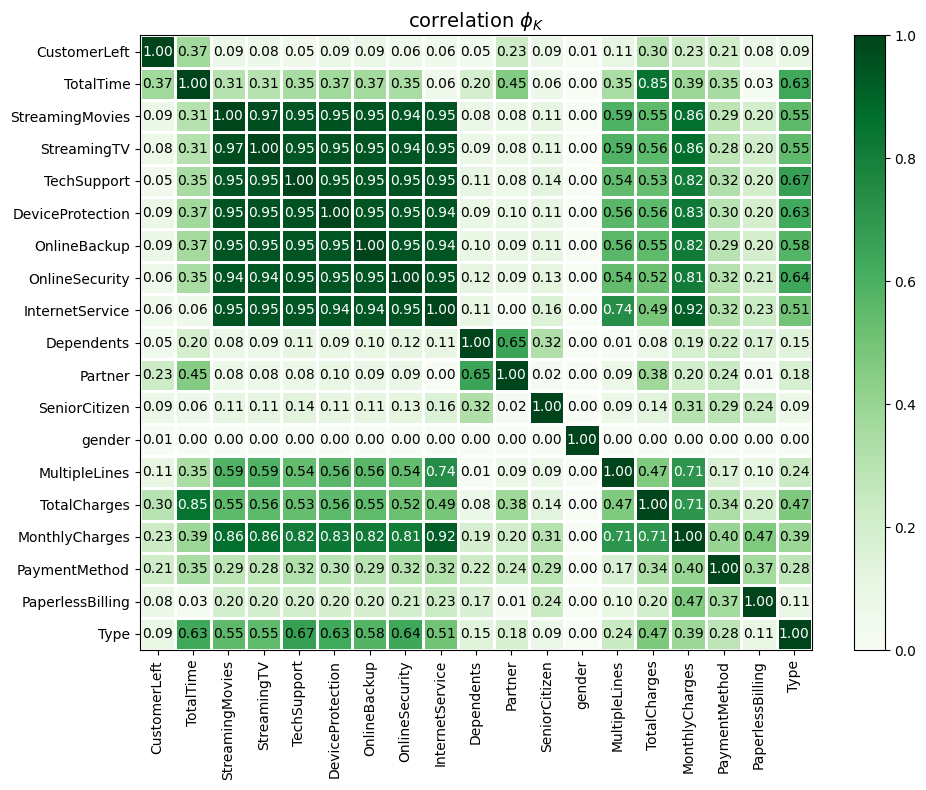

In [ ]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.0,
                        figsize=(10, 8))
plt.tight_layout()

Мы видим высокую корреляцию между признаками StreamingMovies, StreamingTV, TechSupport, DeviceProtection, OnlineBackup, OnlineSecurity и InternetService
Поскольку я планирую использовать Логистическую регрессию - создам дополнительный датасет без этих признаков.

In [ ]:
data_copy = data.drop(['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService'], axis=1)

## Разделение на выборки

Зададим целевой признак и фичи

In [ ]:
target = data['CustomerLeft']
features = data.drop(['CustomerLeft'], axis=1)

Разбьём данные на обучающую и тестовую выборки в соотношении 75:25

In [ ]:
RANDOM_STATE = 220523

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

## Машинное обучение
<b>LogisticRegression</b>

Категориальные признаки для OHE LogisticRegression

In [ ]:
ohe_features_LR = X_train.select_dtypes(include='object').columns.to_list()

print(ohe_features_LR)

['Type', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


Численные признаки для LogisticRegression. SeniorCitizen уже закодирован

In [ ]:
num_features_LR = X_train.select_dtypes(exclude='object').columns.to_list()
num_features_LR.remove('SeniorCitizen')
num_features_LR

['MonthlyCharges', 'TotalCharges', 'TotalTime']

Меняю нули на No

In [ ]:
col = ['MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']


X_train[col] = X_train[col].replace([0], ['No'])

Создаю препроцессор и пайплайн, вывожу выборку до преобразования и уже после взаимодействия с препроцессором.

In [ ]:
preprocessor_lr = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_features_LR),
    ('num', StandardScaler(), num_features_LR)
])
preprocessor_lr.fit(X_train);

#у тебя возможно нужно будет поменять на get_feature_names_out
cat_columns = preprocessor_lr.named_transformers_['cat'].get_feature_names_out(ohe_features_LR)
columns = np.append(cat_columns, num_features_LR)

display(X_train.head(3))
display(pd.DataFrame(preprocessor_lr.transform(X_train), columns=columns))


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TotalTime
customerID,,,,,,,,,,,,,,,,,,
2205-LPVGL,One year,Yes,Bank transfer (automatic),90,5211,Yes,Male,1,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,No,No,1767
5940-NFXKV,Month-to-month,Yes,Electronic check,84,271,Yes,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,92
5453-YBTWV,Two year,Yes,Credit card (automatic),101,7643,No,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,2132


,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,gender_Male,Partner_Yes,Dependents_Yes,...,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MonthlyCharges,TotalCharges,TotalTime
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.837616,1.452790,1.251417
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.638294,-0.883636,-1.197416
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.203040,2.603031,1.785043
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.136599,2.474859,1.785043
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.535244,2.513641,1.652002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.225436,-0.320813,-0.305602
5278,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339311,0.716863,0.849370
5279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.003718,0.763686,0.268960
5280,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.601684,-0.157169,-0.618468


Строю пайплайн, вывожу результат и лучшие гиперпараметры.

In [ ]:
pipeline_lr = Pipeline([
    ('preprocessing_lr', preprocessor_lr),
    ('logreg', LogisticRegression(random_state=220523))])

params_lr = {'logreg__max_iter': [1,10,100,100]}

grid_lr = GridSearchCV(pipeline_lr, params_lr, cv=3, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_score_)

{'logreg__max_iter': 100}
0.7566747665567881


LogisticRegression ROC-AUC 0.75

Делаю поэлементную проверку признаков после OHE

In [ ]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

<b>CatBoostClassifier</b>

Задаю категориальные признаки

In [ ]:
#КОД ТИМЛИДА
cat_col = X_train.select_dtypes('object').columns.to_list()
cat_col

X_train[['MonthlyCharges', 'TotalCharges']] = X_train[['MonthlyCharges', 'TotalCharges']].astype('float')

Подбираю параметры Гридсерчем

In [ ]:
model_cat = CatBoostClassifier(iterations=2000,
                                 loss_function='CrossEntropy',
                                 eval_metric='AUC:hints=skip_train~false',
                                 cat_features=cat_col,
                                 random_state=RANDOM_STATE,
                                 verbose=False)

grid = {'learning_rate': [0.01, 0.1, 0.5, 0.75],
        'depth': [2, 3, 6, 10],
        'l2_leaf_reg': [1, 3, 5]}

grid_search_result = model_cat.grid_search(grid,
                                           X=X_train,
                                           y=y_train,
                                           verbose=False,
                                           cv=3)


bestTest = 0.8516833827
bestIteration = 1994


bestTest = 0.9381907583
bestIteration = 1865


bestTest = 0.9446340767
bestIteration = 314


bestTest = 0.9388298272
bestIteration = 241


bestTest = 0.8497436206
bestIteration = 1997


bestTest = 0.9332135392
bestIteration = 1987


bestTest = 0.9366945852
bestIteration = 613


bestTest = 0.943506308
bestIteration = 368


bestTest = 0.8499616559
bestIteration = 1999


bestTest = 0.9314993309
bestIteration = 1994


bestTest = 0.9363261808
bestIteration = 606


bestTest = 0.926837887
bestIteration = 468


bestTest = 0.8604799783
bestIteration = 1999


bestTest = 0.9377321324
bestIteration = 1437


bestTest = 0.9288979445
bestIteration = 308


bestTest = 0.9340180142
bestIteration = 178


bestTest = 0.8576755936
bestIteration = 1996


bestTest = 0.9361231824
bestIteration = 1949


bestTest = 0.9353337443
bestIteration = 195


bestTest = 0.9274243267
bestIteration = 258


bestTest = 0.8554050193
bestIteration = 1994


bestTest = 0.9320406598


Вывожу результаты

In [ ]:
display(pd.DataFrame(grid_search_result))

,params,cv_results
depth,2.0,NaN
l2_leaf_reg,1.0,NaN
learning_rate,0.5,NaN
iterations,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
test-AUC-mean,NaN,"[0.6184864425961019, 0.7134684296676849, 0.738..."
test-AUC-std,NaN,"[0.03535803490355407, 0.030782934317045086, 0...."
train-AUC-mean,NaN,"[0.6182846019868128, 0.720068819059953, 0.7509..."
train-AUC-std,NaN,"[0.019521861305944268, 0.019070541651937715, 0..."
test-CrossEntropy-mean,NaN,"[0.4825535173436582, 0.4167949242456146, 0.398..."
test-CrossEntropy-std,NaN,"[0.0057677019074648585, 0.014178318209029856, ..."


Вывожу лучший скор

In [ ]:
best_score = model_cat.get_best_score()
display(best_score)

display(best_score['learn']['AUC'])

{'learn': {'CrossEntropy': 0.06633918658169598, 'AUC': 0.9972005320747719}}

0.9972005320747719

CatBoostClassifier ROC-AUC 0.99

<b>LGBMClassifier</b>

LGBM не принимал у меня фичи, хотя написано, что для него признаки не надо кодировать. Мне подсказали такой вариант. Я правда, не очень понимаю, смысл этой операции. Записала это в вопросы.

In [ ]:
X_train_light = X_train.copy()
X_train_light = X_train_light.astype({"Type": 'category', "PaperlessBilling": 'category', "PaymentMethod": 'category',
                                      "MultipleLines": 'category', "gender": 'category', "Partner": 'category',
                                      "Dependents": 'category', "InternetService": 'category', "OnlineSecurity": 'category',
                                      "OnlineBackup": 'category', "DeviceProtection": 'category', "TechSupport": 'category',
                                      "StreamingTV": 'category', "StreamingMovies": 'category', "MonthlyCharges": 'category',
                                      "TotalCharges": 'category'})

In [ ]:
X_test_light = X_test.copy()
X_test_light = X_test_light.astype({"Type": 'category', "PaperlessBilling": 'category', "PaymentMethod": 'category',
                                      "MultipleLines": 'category', "gender": 'category', "Partner": 'category',
                                      "Dependents": 'category', "InternetService": 'category', "OnlineSecurity": 'category',
                                      "OnlineBackup": 'category', "DeviceProtection": 'category', "TechSupport": 'category',
                                      "StreamingTV": 'category', "StreamingMovies": 'category', "MonthlyCharges": 'category',
                                      "TotalCharges": 'category'})


Подбираю параметры Гридсерчем

In [ ]:
%%time
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_lgbm = {'n_estimators': [300, 500, 1000], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 5, 9], 'num_threads':[1]}
search_lgbm = GridSearchCV(model_lgbm, param_lgbm, cv=5, scoring='roc_auc')
search_lgbm.fit(X_train_light, y_train)

print('best_params_', search_lgbm.best_params_)
print('ROC-AUC: ', search_lgbm.best_score_)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

LGBMClassifier ROC-AUC 0.87

Выведем результаты по трем моделям

In [ ]:
index = ['LogisticRegression',
         'CatBoostClassifier',
         'LGBMClassifier'
        ]

data = {'ROC-AUC':[grid_lr.best_score_.round(2),
                   best_score['learn']['AUC'],
                   search_lgbm.best_score_.round(2)]}

best_model = pd.DataFrame(data=data, index=index)

In [ ]:
best_model

,ROC-AUC
LogisticRegression,0.760000
CatBoostClassifier,0.997201
LGBMClassifier,0.880000


Лучшая модель на трейне - CatBoostClassifier, показатель AUC-ROC 0.99

## Проверка качества лучшей модели на тестовой выборке

In [ ]:
model_cat_predictions = model_cat.predict(X_test)

In [ ]:
model_cat_probabilities = model_cat.predict_proba(X_test)[:,1]
print('ROC-AUC:', roc_auc_score(y_test, model_cat_probabilities))

ROC-AUC: 0.9393432804728797


Выведем на экран параметры лучшей модели

In [ ]:
print(model_cat.get_params())

{'iterations': 100, 'loss_function': 'CrossEntropy', 'verbose': False, 'eval_metric': 'AUC:hints=skip_train~false', 'random_state': 220523, 'cat_features': ['Type', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], 'depth': 8, 'learning_rate': 0.35}


## Исследование важности признаков лучшей модели

Визуализируем важность признаков с помощью возможностей библиотеки shap

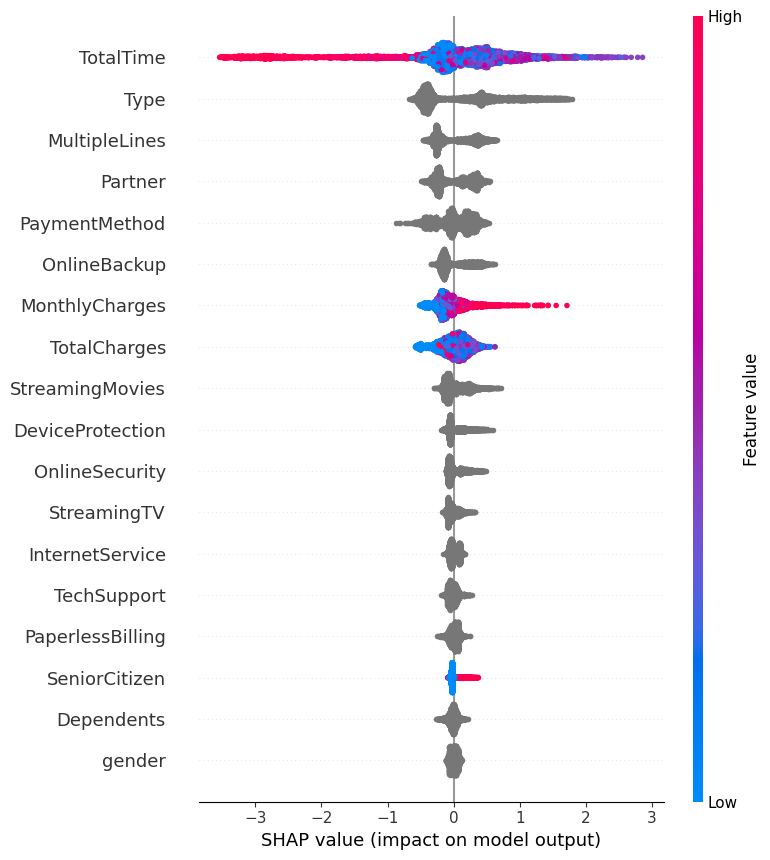

In [ ]:
explainer = shap.Explainer(model_cat)
shap_values = explainer.shap_values(X_train)
feature_names = X_train.columns.tolist()
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

Признаки, которые влияют сильнее всего на решение клиента уйти или остаться это:
- 'TotalTime'
- 'TotalCharges'
- 'MonthlyCharges'
- 'Type'


Матрица ошибок

[Text(0.5, 1.0, 'Матрица ошибок'),
 Text(0.5, 36.72222222222221, 'Предсказания'),
 Text(45.722222222222214, 0.5, 'Правильные ответы')]

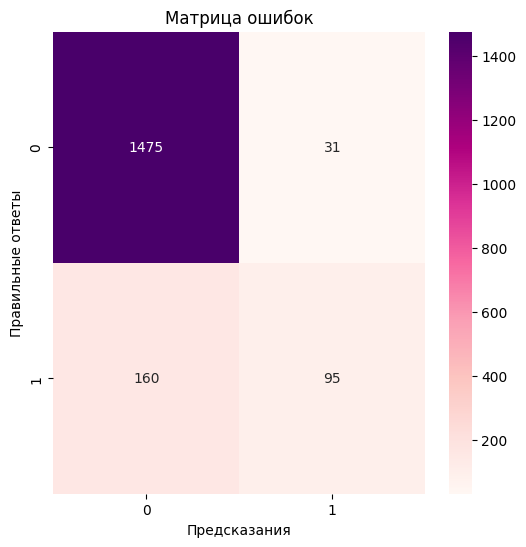

In [ ]:
cmatrix = confusion_matrix(y_test, model_cat_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cmatrix,
            annot=True,
            cmap='RdPu',
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')

<b>Выводы:</b>
- Добавила столбец 'TotalTime', который показывает срок жизни клиента в компании в днях. Удалила столбцы 'EndDate' и'BeginDate'.
- Добавила столбец 'CustomerLeft'
- В "ушедших клиентах" присутсвует дисбаланс классов, я не стала это корректировать, т.к. метрика ROC-AUC не чувствительна к нему.
- Построила матрицу корреляции 𝜙k. Наблюдается корреляция между признаками StreamingMovies, StreamingTV, TechSupport, DeviceProtection, OnlineBackup, OnlineSecurity и InternetService. Однако, я не удаляла их, т.к. catboost и lgbm устойчивы к корреляции, а для логистической регрессии в данном случае это не критично.
- Поменяла 0 на No
- Разбила данные на обучающую и тестовую выборки в соотношении 75:25, задала таргет -  'CustomerLeft'
- Обучила на тренивочной выборке 3 модели LogisticRegression, CatBoost, LGBM.
- Лучший результат ROC-AUC показала CatBoost - 0,99
- Я протестировала CatBoost на тестовой выборке, модель показала такой же результат 0,94.
- Построив feature importance я обнаружила, что ризнаки, которые влияют сильнее всего на решение клиента уйти или остаться это: 'TotalTime', 'TotalCharges', 'MonthlyCharges', 'Type'.
- Я проанализировала матрицу ошибок - TPR - 1482, FPR - 71, FNR - 24, TNR - 184

# Отчет

## Какие трудности возникли, какие ключевые шаги выделяем?

<b>Ключевые шаги проекта:</b>

1. Предварительная обработка данных
2. Обучение моделей
3. Достижение необходимого показателя метрики
4. Выводы и составление отчета

## Лучшая модель, гиперпараметры.

Лучшая модель для решения данной задачи - это CatBoostClassifier с параметрами:

- 'iterations': 2000,
- 'loss_function': 'CrossEntropy',
- 'verbose': 200,
- 'eval_metric': 'AUC:hints=skip_train~false',
- 'random_state': 220523,
- 'cat_features': ['Type', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
- 'depth': 2,
- 'l2_leaf_reg': 1,
- 'learning_rate': 0.5

## Список признаков используемых для обучения лучшей модели.

Для обучения лучшей модели я использовала признаки:

- Type
- PaperlessBilling
- PaymentMethod
- MonthlyCharges
- TotalCharges
- MultipleLines
- gender
- SeniorCitizen
- Partner
- Dependents
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- TotalTime

Столбцы с временм начала и окончания сотрудничества я удалила.

Признаки, оказавшие наибольшее влияние, это:
- 'TotalTime'
- 'TotalCharges'
- 'MonthlyCharges'
- 'Type'

В итоге получилось достичь показатель метрики ROC-AUC 0.94 на тестовой выборке , что соотвествует требованиям заказчика(ROC-AUC>0.85)